In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as m
import sympy as sm

## Lab 1 -- Low Pass Filter Analysis

# Important Equations

Equation 4:

# Measured Quantities
Resistance = 1.192 kΩ +/- 6e-3\
Capacitance = 0.033 µF +/- 1.66e-4

# Lab Data:
| Frequency (Hz) | Vin (divs) +/- 0.05 | Vin Scale | Vout (divs) +/- 0.1 | Vout Scale | Period (Divs) +/- 0.1 | Time Scale (micro secs) |
|----------------|---------------------|-----------|---------------------|------------|-----------------------|-------------------------|
| 100            | 4                   | 5         | 3.9                 | 5          | 4                     | 2500                    |
| 300            | 3.95                | 5         | 3.9                 | 5          | 6.33                  | 500                     |
| 1000           | 4                   | 5         | 3.75                | 5          | 2                     | 500                     |
| 3000           | 4                   | 5         | 3                   | 5          | 3.33                  | 100                     |
| 10 000         | 4                   | 5         | 1.4                 | 5          | 4                     | 25                      |
| 30 000         | 4                   | 5         | 0.5                 | 5          | 3.3                   | 10                      |
| 100 000        | 4                   | 5         | 1.75                | 0.5        | 3.9                   | 2.5                     |


In [2]:
resistance_ohms = 1192
resistanceError_ohms = 6

capacitance_farads = 0.033*(10**-6)
capacitanceError_farads = 1.66*(10**-10)

# Analysis

In [3]:
def transferFunction(freq, resistance, capacitance):
    angularFreq = 2*m.pi*freq
    return 1/((1 + (angularFreq * resistance * capacitance)**2)**(1/2))

freqRange = np.logspace(2, 5, num=200)

expectedTransferVals = transferFunction(freqRange, resistance_ohms, capacitance_farads)

# Error Values Based on Frequency
Found by using the given error propagation notebook to evaluate at each point

# Most of these are garbage, only the one I labeled as correct is good

In [6]:
def solveExpressionWithError1D(stringExpression, varValError):
    '''
    This function evaluates an expression and gives the error, and fractional contribution to the 
    total error by each variable. The function takes an input expression in the form of a string, 
    and a list of as many 3 element tuples as there are variables in the expression of the form
    ('differentiationVariable', evaluationValue, errorOnValue)
    '''
    
    # Converting the given expression in the form of a string to a sympy expression
    symbolicExpression = sm.sympify(stringExpression)

    # First step is to evaluate the function at the given values
    ans = symbolicExpression.subs([(sm.symbols(var), val) for var, val, _ in varValError])

    totalError = 0
    individualErrors = {}
    
    for var, _, error in varValError:
        symPartialDerivative = sm.diff(symbolicExpression, sm.symbols(var))
        evaluatedPartial = symPartialDerivative.subs([(sm.symbols(var), val) for var, val, _ in varValError])
        
        individualErrors[var] = (evaluatedPartial * error)**2
        totalError += individualErrors[var]

    # Both the individual and total error have already been squared so this is the easiest spot
    # to calculate the fractional contribution of each variable to the error
    fractionalContribution = {var: indError/totalError for var, indError in individualErrors.items()}

    # The last step to solving the equation for the actual error is to take the root of the error from this point
    totalError **= (1/2)

    return ans, totalError, fractionalContribution

In [7]:
def solveExpressionWithError(stringExpression, varValError):
    '''# This function evaluates an expression and gives the error, and fractional contribution to the 
    total error by each variable. The function takes an input expression in the form of a string, 
    and a list of as many 3 element tuples as there are variables in the expression of the form
    ('differentiationVariable', evaluationValue, errorOnValue) 
    
    As of right now, only the first specified variable can be passed through as an list/numpy array

    '''

    
    # Converting the given expression in the form of a string to a sympy expression
    symbolicExpression = sm.sympify(stringExpression)

    # First step is to evaluate the function at the given values
    singleInputAnswers = []
    multiInputAnswers = []

    listArrayCheck = False   
    if(isinstance(varValError[0][1], (int, float))):
        singleInputAnswers.append(symbolicExpression.subs([(sm.symbols(var), val) for var, val, _ in varValError]))
    elif(isinstance(varValError[0][1], (list, np.ndarray))):
        listArrayCheck = True
        tempAnswers = []
        for listVal in varValError[0][1]:
            for j, (var, val, _) in enumerate(varValError[0][1]):
                if j == 0:
                    tempAnswers.append(symbolicExpression.subs((sm.symbols(var), listVal)))
                else:
                    tempAnswers.append(symbolicExpression.subs((sm.symbols(var), val)))
        multiInputAnswers.append(tempAnswers)
    else: raise TypeError(f"Unsupported type for {varValError[0][1]}: {type(varValError[0][1])}. Expected int or float.")
    
    if len(multiInputAnswers) > 0:
        ans = np.array(multiInputAnswers)+ sum(singleInputAnswers) 
    else:     
        ans = sum(singleInputAnswers)

    totalError = 0
    individualErrors = {}
    
    for var, _, error in varValError:
        symPartialDerivative = sm.diff(symbolicExpression, sm.symbols(var))

        if(listArrayCheck):
            evaluatedPartial = symPartialDerivative.subs([(sm.symbols(var), val[0] if isinstance(val, (list, np.ndarray)) else val) for var, val, _ in varValError])           
        else:    
            evaluatedPartial = symPartialDerivative.subs([(sm.symbols(var), val) for var, val, _ in varValError])
        
        individualErrors[var] = (evaluatedPartial * error)**2
        totalError += individualErrors[var]

    # Both the individual and total error have already been squared so this is the easiest spot
    # to calculate the fractional contribution of each variable to the error
    fractionalContribution = {var: indError/totalError for var, indError in individualErrors.items()}

    # The last step to solving the equation for the actual error is to take the root of the error from this point
    totalError **= (1/2)

    return ans, totalError, fractionalContribution

# Working Error Analysis

In [8]:
exp = "1/((1+(f*R*C)**2)**1/2)"

diffVars = ['f', 'R', 'C']
diffVals = [freqRange, resistance_ohms, capacitance_farads]
errs = [0, resistanceError_ohms, capacitanceError_farads]

vve = list(zip(diffVars, diffVals, errs))

VerrorPropResults = []
for freq in freqRange:
    vve[0] = ('f', freq, 0)
    VerrorPropResults.append(solveExpressionWithError1D(exp, vve))

Vresults, Verrors, VfracErrors = zip(*VerrorPropResults)

VproperResults = np.array(Vresults)
VproperErrors = np.array(Verrors)

VfractionalContribution = VfracErrors[1]
print(VfractionalContribution)

VerrorAbove = expectedTransferVals + VproperErrors
VerrorBelow = expectedTransferVals - VproperErrors

dbTransferVals = 20*np.log10(expectedTransferVals)
dbErrorAbove = []
dbErrorBelow = []

for a in VerrorAbove:
    dbErrorAbove.append(20*m.log10(a))
np.array(dbErrorAbove)

for b in VerrorBelow:
    dbErrorBelow.append(20*m.log10(b))
np.array(dbErrorBelow)

{'f': 0, 'R': 0.500323336802345, 'C': 0.499676663197655}


In [31]:
def err (vin, vinError, vout, voutError):
    return (((((vout+voutError)/vin)-(vout/vin))**2) + ((vout/(vin+vinError))-(vout/vin))**2)**(1/2)

In [90]:
Vin = np.array([4, 3.95, 4, 4, 4, 4, 4])
Vout = np.array([3.9, 3.9, 3.75, 3, 1.4, 0.5, 0.175])
measuredFreqs = np.array([100, 300, 1000, 3000, 10000, 30000, 100000])

VRatio_ratio = Vout/Vin

VRatio_dB = 20*np.log10(VRatio_ratio)

VRatioError = err(Vin, 0.05, Vout, 0.1)
print(VRatio_ratio)
print(VRatioError)

measuredVError_db = abs(VRatio_dB - 20*np.log10(VRatio_ratio + VRatioError))

print(VRatio_dB)
print(measuredVError_db)

np.savetxt("VoutVinErrs.csv", np.array([VRatio_ratio, VRatioError, VRatio_dB, measuredVError_db]), delimiter=",")


[0.975      0.98734177 0.9375     0.75       0.35       0.125
 0.04375   ]
[0.0277469  0.02816456 0.02754921 0.02665959 0.02537067 0.02504758
 0.02500583]
[ -0.21990769  -0.11064977  -0.56057447  -2.49877473  -9.11863911
 -18.06179974 -27.18043885]
[0.24373422 0.24430246 0.2515637  0.30338895 0.60784584 1.58637992
 3.92662994]


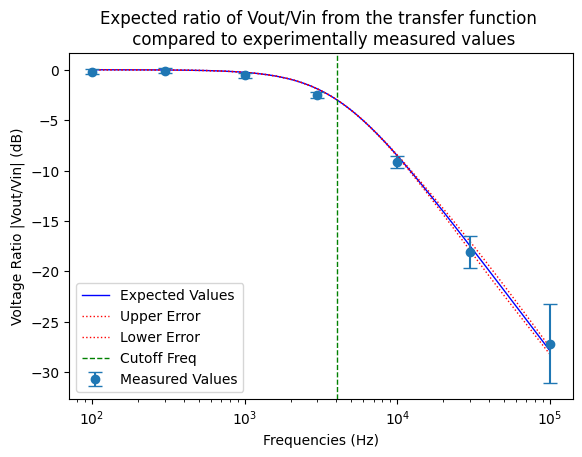

In [86]:

plt.figure(figsize=(6.5,4.5))

plt.plot(freqRange, dbTransferVals, label="Expected Values", color='b', linewidth=1)
plt.plot(freqRange, dbErrorAbove, label="Upper Error", color='r', linestyle="dotted", linewidth=1)
plt.plot(freqRange, dbErrorBelow, label="Lower Error", color='r', linestyle="dotted", linewidth=1)

plt.errorbar(measuredFreqs, measuredRatios, yerr=measuredVError_db, fmt='o', capsize=5, label='Measured Values')

plt.axvline(x = 1/(2*m.pi*1193* 0.000000033), color = 'g', linestyle="dashed", label = 'Cutoff Freq', linewidth=1)

plt.xscale("log")

plt.title("Expected ratio of Vout/Vin from the transfer function \n compared to experimentally measured values")
plt.xlabel("Frequencies (Hz)")
plt.ylabel("Voltage Ratio |Vout/Vin| (dB)")
plt.legend()

plt.savefig("Lab1VoutVinPlot.png")

plt.show()

In [64]:
def phi(F, R, C):
    return -1*np.arctan(2*(m.pi)*F*R*C)

def phaseShift(deltaT, period):
    return (deltaT/period)*2*m.pi

def phaseShiftErr(deltaT, deltaTErr, period, periodErr):
    twoPi = 2*m.pi
    return (((twoPi*(((deltaT+deltaTErr)/period)-(deltaT/period)))**2)+((twoPi*((deltaT/(period+periodErr)-(deltaT/period))))**2))**(1/2)

In [62]:
# Getting expected values from phi function and it's error
phiExp = "-1*atan(2*pi*f*R*C)"

PhaseErrorPropResults = []
for freq in freqRange:
    vve[0] = ('f', freq, 0)
    PhaseErrorPropResults.append(solveExpressionWithError1D(phiExp, vve))

Presults, Perrors, PfracErrors = zip(*PhaseErrorPropResults)

PproperResults = np.array(Presults)
PproperErrors = np.array(Perrors)

PfractionalContribution = PfracErrors[1]
print(PfractionalContribution)

expectedPhi = phi(freqRange, resistance_ohms, capacitance_farads)

errorAbove = expectedPhi + PproperErrors
errorBelow = expectedPhi - PproperErrors

{'f': 0, 'R': 0.500323336802345, 'C': 0.499676663197655}


In [70]:
# Prepping measured values and the errors on them

period_divs = np.array([4.0, 6.7, 2.0, 3.4, 4.0, 3.275, 4])
periodError_divs = 0.1

timeShift_divs = np.array([0, -0.05, -0.10, -0.35, -0.80, -0.80, -1])
timeShiftError_divs = 0.1

phaseShift_rad = phaseShift(timeShift_divs, period_divs)

phaseShiftError_rad = phaseShiftErr(timeShift_divs, timeShiftError_divs, period_divs, periodError_divs)

print(phaseShiftError_rad)


[0.15707963 0.09378142 0.31451525 0.18572127 0.16004191 0.19716911
 0.16168435]


In [92]:
# Exporting Data to CSV
np.savetxt("VoutVinErrs.csv", np.array([period_divs, timeShift_divs, phaseShift_rad, phaseShiftError_rad]), delimiter=",")

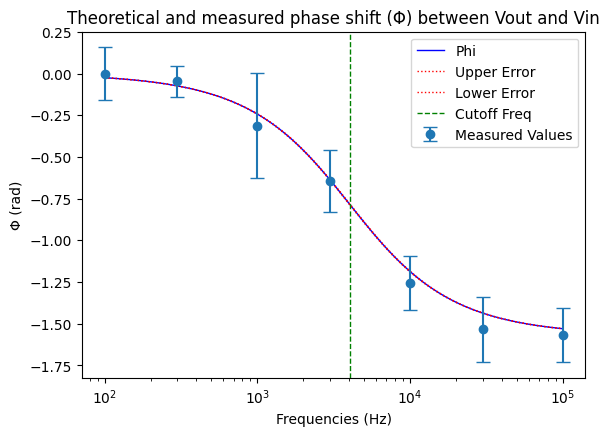

In [84]:


plt.figure(figsize=(6.5,4.5))
 
plt.plot(freqRange, expectedPhi, label="Phi", color='b', linewidth=1)
plt.plot(freqRange, errorAbove, label="Upper Error", color='r', linestyle="dotted", linewidth=1)
plt.plot(freqRange, errorBelow, label="Lower Error", color='r', linestyle="dotted", linewidth=1)

plt.errorbar(measuredFreqs, phaseShift_rad, yerr=phaseShiftError_rad, fmt='o', capsize=5, label='Measured Values')

plt.axvline(x = 1/(2*m.pi*1193* 0.000000033), color = 'g', linestyle="dashed", label = 'Cutoff Freq', linewidth=1)

plt.xscale("log")
 
plt.title("Theoretical and measured phase shift (Φ) between Vout and Vin")

plt.xlabel("Frequencies (Hz)")

plt.ylabel("Φ (rad)")

plt.legend()

plt.savefig("Lab1PhaseShiftPlot.png")

plt.show()